# 02 - Cross-Validation & Data Splits

**Goal:** Understand and visualize how we split our data for training, validation, and testing.

---

## Why This Matters

**Time-series data is special!** We cannot use random splits like in standard ML.

### The Problem with Random Splits
- Agent could see "future" data during training
- Results would be unrealistically good
- Model wouldn't work in real trading

### Our Solution: Time-Based Splits
- **Train:** Historical data (agent learns here)
- **Validation:** Recent past (tune hyperparameters)
- **Test:** Most recent data (final evaluation, never seen during training)

---

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

✓ Imports successful


## Step 1: Load Prepared Data

Load the featured data from Notebook 01.

In [2]:
# Load data
data_path = Path('demo_data/featured_data.parquet')

if not data_path.exists():
    print("❌ Error: Data file not found!")
    print("   Please run notebook 01_data_collection.ipynb first")
else:
    data = pd.read_parquet(data_path)
    print(f"✓ Loaded data: {len(data)} rows")
    print(f"  Date range: {data.index[0].date()} to {data.index[-1].date()}")
    print(f"  Columns: {len(data.columns)}")
    
data.head()

✓ Loaded data: 6089 rows
  Date range: 2000-10-16 to 2024-12-30
  Columns: 41


Price,close,high,low,open,volume,ticker,return_1d,return_3d,return_5d,return_10d,...,bb_percent,bb_width,atr,atr_pct,obv,obv_sma,obv_std,obv_norm,volume_sma,volume_ratio
Date,,,,,,,,,,,,,,,,,,,,,
2000-10-16,87.955597,87.985433,87.000855,87.458336,5659000,SPY,0.004543,0.012131,-0.012946,-0.039322,...,0.235156,9.572629,1.768648,0.020108,-89447300,-74209100.0,1.349966e+07,-1.128784,7588695.0,0.745715
2000-10-17,85.767647,88.194282,85.548852,88.114721,7831700,SPY,-0.024876,0.012206,-0.021335,-0.054386,...,0.047718,10.131393,1.831275,0.021352,-97279000,-76291440.0,1.369397e+07,-1.532614,7650870.0,1.023635
2000-10-18,85.449417,86.642845,82.843767,84.415113,10897300,SPY,-0.003710,-0.024080,-0.016708,-0.065681,...,0.073830,10.739348,1.971833,0.023076,-108176300,-78593240.0,1.499718e+07,-1.972575,7870330.0,1.384605
2000-10-19,88.671646,88.761153,86.841724,87.100300,8767300,SPY,0.037709,0.008141,0.046478,-0.033811,...,0.419683,10.701854,2.067540,0.023317,-99409000,-80158060.0,1.547132e+07,-1.244299,8010080.0,1.094533
2000-10-20,89.049599,89.865108,88.074966,88.074966,7373500,SPY,0.004262,0.038266,0.017038,-0.008196,...,0.476011,10.262380,2.047726,0.022995,-92035500,-81743770.0,1.494756e+07,-0.688523,7989190.0,0.922935


## Step 2: Define Split Boundaries

We'll use a simple time-based split:

```
2000 ──────────────────────── 2019 ──── 2021 ──── 2024
       TRAIN (85%)              VAL(15%) TEST(Hold-out)
```

### Why These Dates?
- **Train:** 2000-2018 (longest period for learning)
- **Validation:** 2019-2020 (tune and select best model)
- **Test:** 2021-2024 (final evaluation on unseen data)

In [3]:
# Define split dates
test_start_date = pd.Timestamp('2021-01-01')

# Split data
train_val_data = data[data.index < test_start_date].copy()
test_data = data[data.index >= test_start_date].copy()

# Further split train_val into train and validation (85/15 split)
train_size = int(len(train_val_data) * 0.85)
train_data = train_val_data.iloc[:train_size]
val_data = train_val_data.iloc[train_size:]

print("Data Split Summary")
print("=" * 70)
print(f"\nTRAIN SET:")
print(f"  Dates: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"  Rows: {len(train_data):,}")
print(f"  Percentage: {len(train_data)/len(data)*100:.1f}%")

print(f"\nVALIDATION SET:")
print(f"  Dates: {val_data.index[0].date()} to {val_data.index[-1].date()}")
print(f"  Rows: {len(val_data):,}")
print(f"  Percentage: {len(val_data)/len(data)*100:.1f}%")

print(f"\nTEST SET (HOLD-OUT):")
print(f"  Dates: {test_data.index[0].date()} to {test_data.index[-1].date()}")
print(f"  Rows: {len(test_data):,}")
print(f"  Percentage: {len(test_data)/len(data)*100:.1f}%")

print(f"\nTOTAL: {len(data):,} rows")

Data Split Summary

TRAIN SET:
  Dates: 2000-10-16 to 2017-12-19
  Rows: 4,322
  Percentage: 71.0%

VALIDATION SET:
  Dates: 2017-12-20 to 2020-12-31
  Rows: 763
  Percentage: 12.5%

TEST SET (HOLD-OUT):
  Dates: 2021-01-04 to 2024-12-30
  Rows: 1,004
  Percentage: 16.5%

TOTAL: 6,089 rows


## Step 3: Visualize the Split

Let's see exactly where our splits occur in the price history.

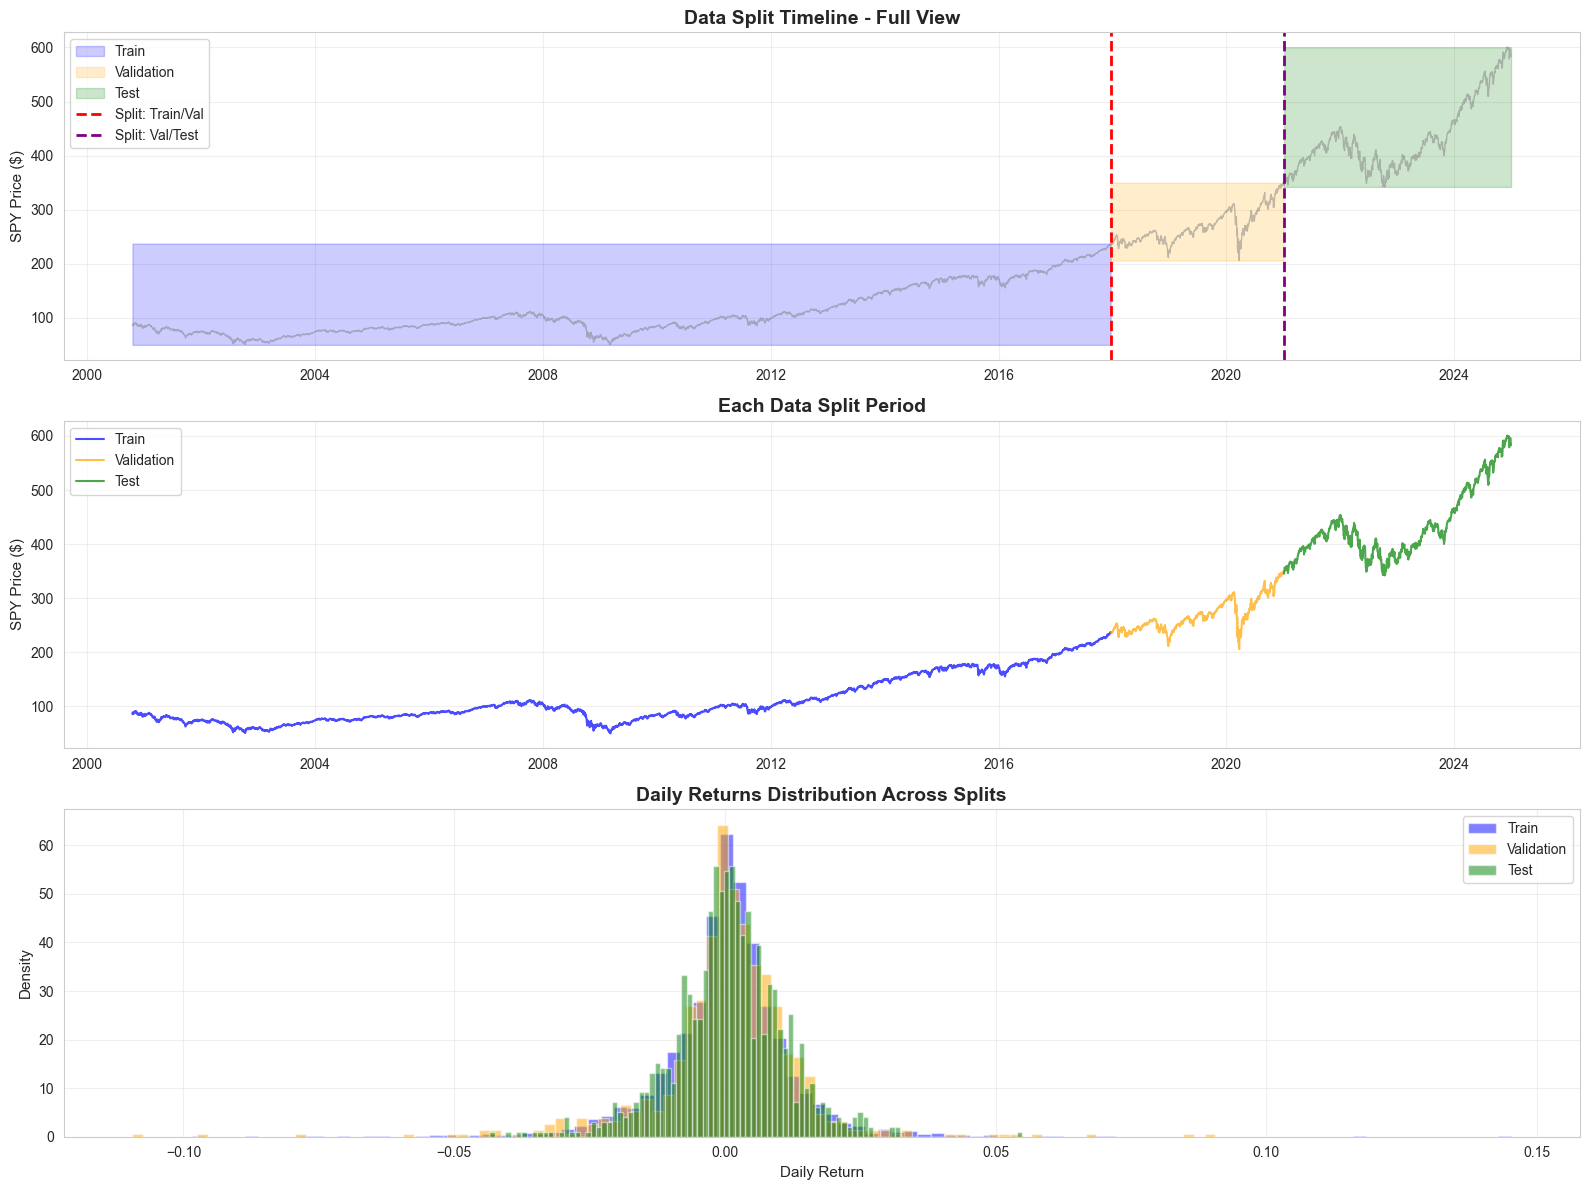

✓ Saved visualization: demo_outputs/data_splits.png


In [4]:
# Create comprehensive split visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Full timeline with colored regions
ax1 = axes[0]
ax1.plot(data.index, data['close'], linewidth=1, color='gray', alpha=0.5)

# Color the regions
ax1.fill_between(train_data.index, train_data['close'].min(), train_data['close'].max(),
                  alpha=0.2, color='blue', label='Train')
ax1.fill_between(val_data.index, val_data['close'].min(), val_data['close'].max(),
                  alpha=0.2, color='orange', label='Validation')
ax1.fill_between(test_data.index, test_data['close'].min(), test_data['close'].max(),
                  alpha=0.2, color='green', label='Test')

ax1.axvline(x=train_data.index[-1], color='red', linestyle='--', linewidth=2, label='Split: Train/Val')
ax1.axvline(x=test_data.index[0], color='purple', linestyle='--', linewidth=2, label='Split: Val/Test')

ax1.set_title('Data Split Timeline - Full View', fontsize=14, fontweight='bold')
ax1.set_ylabel('SPY Price ($)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Individual periods side by side
ax2 = axes[1]
ax2.plot(train_data.index, train_data['close'], label='Train', linewidth=1.5, color='blue', alpha=0.7)
ax2.plot(val_data.index, val_data['close'], label='Validation', linewidth=1.5, color='orange', alpha=0.7)
ax2.plot(test_data.index, test_data['close'], label='Test', linewidth=1.5, color='green', alpha=0.7)
ax2.set_title('Each Data Split Period', fontsize=14, fontweight='bold')
ax2.set_ylabel('SPY Price ($)', fontsize=11)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Returns distribution across splits
ax3 = axes[2]
ax3.hist(train_data['return_1d'].dropna(), bins=100, alpha=0.5, label='Train', color='blue', density=True)
ax3.hist(val_data['return_1d'].dropna(), bins=100, alpha=0.5, label='Validation', color='orange', density=True)
ax3.hist(test_data['return_1d'].dropna(), bins=100, alpha=0.5, label='Test', color='green', density=True)
ax3.set_title('Daily Returns Distribution Across Splits', fontsize=14, fontweight='bold')
ax3.set_xlabel('Daily Return', fontsize=11)
ax3.set_ylabel('Density', fontsize=11)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('demo_outputs/data_splits.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: demo_outputs/data_splits.png")

## Step 4: Compare Statistics Across Splits

Let's verify that our splits are reasonable by comparing basic statistics.

In [5]:
# Calculate statistics for each split
def get_split_stats(df, name):
    returns = df['return_1d'].dropna()
    return {
        'Split': name,
        'Mean Return': returns.mean(),
        'Std Return': returns.std(),
        'Sharpe': (returns.mean() / returns.std()) * np.sqrt(252),
        'Min Return': returns.min(),
        'Max Return': returns.max(),
        'Price Start': df['close'].iloc[0],
        'Price End': df['close'].iloc[-1],
        'Total Return': (df['close'].iloc[-1] / df['close'].iloc[0]) - 1
    }

stats_df = pd.DataFrame([
    get_split_stats(train_data, 'Train'),
    get_split_stats(val_data, 'Validation'),
    get_split_stats(test_data, 'Test')
])

print("\nStatistics Comparison Across Splits")
print("=" * 100)
print(stats_df.to_string(index=False))

# Check for significant differences
print("\n" + "=" * 100)
print("Observations:")
print(f"  • Train period total return: {stats_df.loc[0, 'Total Return']:.1%}")
print(f"  • Validation period total return: {stats_df.loc[1, 'Total Return']:.1%}")
print(f"  • Test period total return: {stats_df.loc[2, 'Total Return']:.1%}")
print(f"  • Train volatility: {stats_df.loc[0, 'Std Return']:.4f}")
print(f"  • Test volatility: {stats_df.loc[2, 'Std Return']:.4f}")


Statistics Comparison Across Splits
     Split  Mean Return  Std Return   Sharpe  Min Return  Max Return  Price Start  Price End  Total Return
     Train     0.000303    0.012080 0.397935   -0.098448    0.145197    87.955597 236.492828      1.688775
Validation     0.000617    0.014316 0.684374   -0.109424    0.090603   236.368912 350.039429      0.480903
      Test     0.000562    0.010388 0.859407   -0.043482    0.054954   345.274078 583.110535      0.688834

Observations:
  • Train period total return: 168.9%
  • Validation period total return: 48.1%
  • Test period total return: 68.9%
  • Train volatility: 0.0121
  • Test volatility: 0.0104


## Step 5: Feature Distribution Check

Verify that feature distributions are similar across splits (important for generalization).

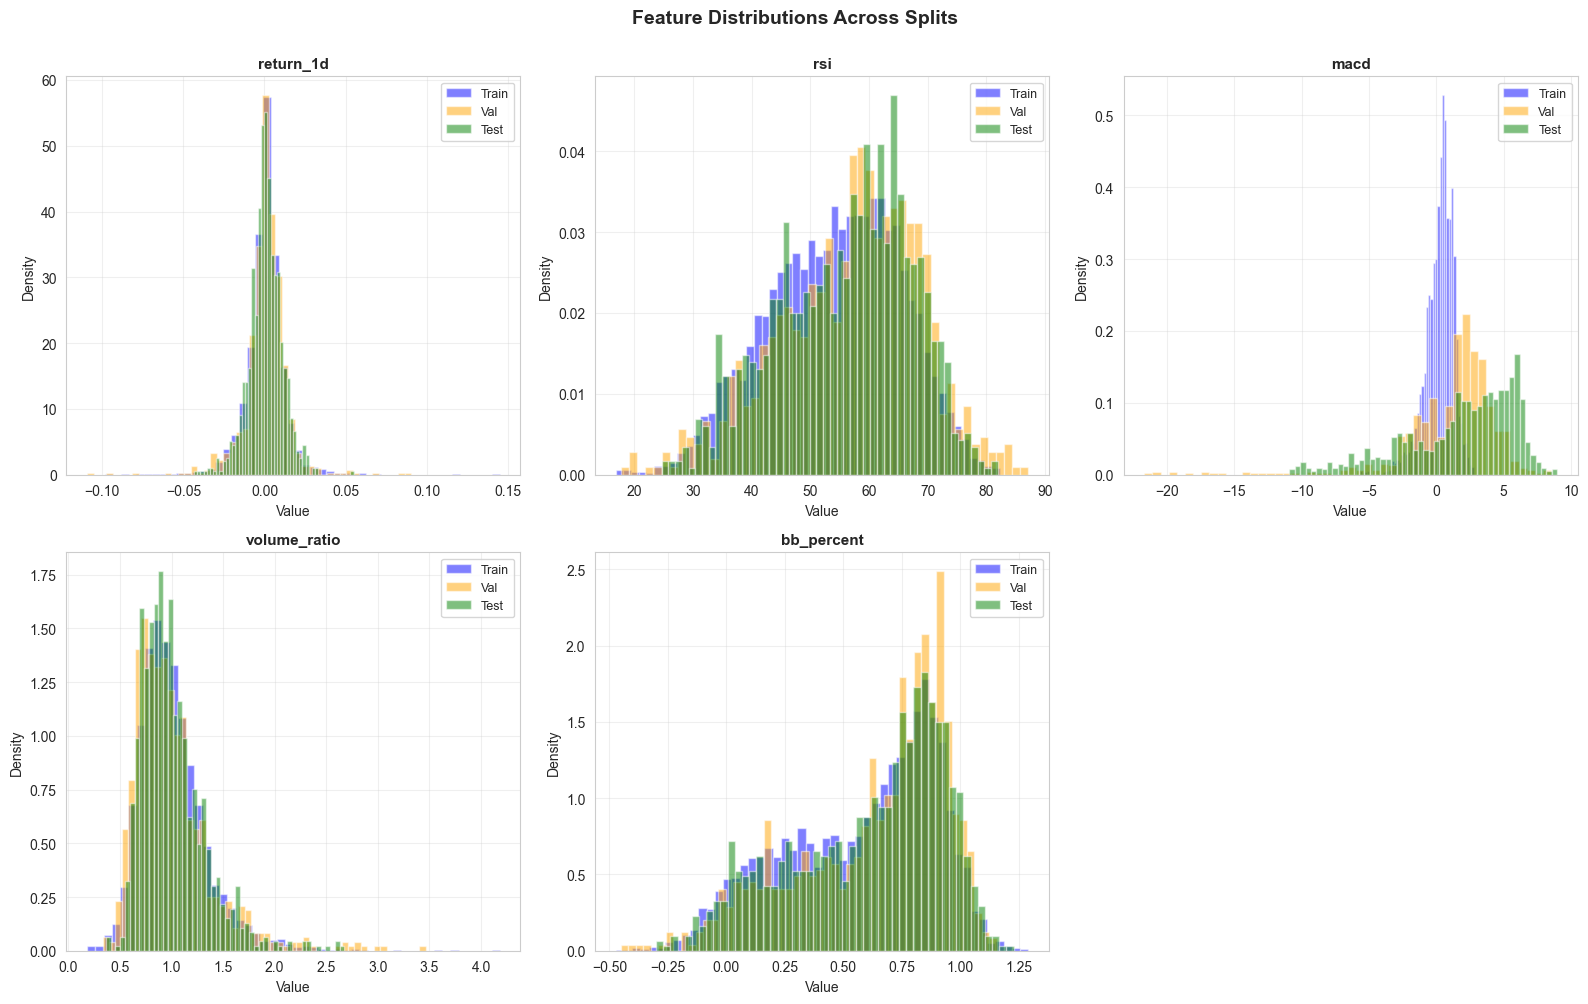

✓ Saved visualization: demo_outputs/feature_distributions.png


In [6]:
# Select key features to compare
key_features = ['return_1d', 'rsi', 'macd', 'volume_ratio', 'bb_percent']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Plot distributions
    train_data[feature].dropna().hist(bins=50, alpha=0.5, label='Train', 
                                       color='blue', density=True, ax=ax)
    val_data[feature].dropna().hist(bins=50, alpha=0.5, label='Val', 
                                     color='orange', density=True, ax=ax)
    test_data[feature].dropna().hist(bins=50, alpha=0.5, label='Test', 
                                      color='green', density=True, ax=ax)
    
    ax.set_title(f'{feature}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('Feature Distributions Across Splits', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('demo_outputs/feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: demo_outputs/feature_distributions.png")

## Step 6: Verify No Data Leakage

Critical check: Ensure validation and test sets come AFTER training set in time.

In [7]:
# Temporal ordering check
print("Data Leakage Check")
print("=" * 70)

train_end = train_data.index[-1]
val_start = val_data.index[0]
val_end = val_data.index[-1]
test_start = test_data.index[0]

print(f"\nTemporal Order:")
print(f"  Train ends:       {train_end.date()}")
print(f"  Validation starts: {val_start.date()}")
print(f"  Gap:              {(val_start - train_end).days} days")
print(f"  ")
print(f"  Validation ends:  {val_end.date()}")
print(f"  Test starts:      {test_start.date()}")
print(f"  Gap:              {(test_start - val_end).days} days")

# Verify no overlap
if train_end < val_start and val_end < test_start:
    print("\n✓ PASS: No temporal overlap detected")
    print("  • Train period is before validation")
    print("  • Validation period is before test")
    print("  • No data leakage possible")
else:
    print("\n❌ FAIL: Temporal overlap detected!")
    print("  This would cause data leakage.")

# Check for duplicate indices
train_indices = set(train_data.index)
val_indices = set(val_data.index)
test_indices = set(test_data.index)

train_val_overlap = train_indices.intersection(val_indices)
val_test_overlap = val_indices.intersection(test_indices)
train_test_overlap = train_indices.intersection(test_indices)

if not train_val_overlap and not val_test_overlap and not train_test_overlap:
    print("\n✓ PASS: No index overlap between splits")
else:
    print(f"\n❌ FAIL: Index overlap found!")
    if train_val_overlap:
        print(f"  Train-Val overlap: {len(train_val_overlap)} rows")
    if val_test_overlap:
        print(f"  Val-Test overlap: {len(val_test_overlap)} rows")
    if train_test_overlap:
        print(f"  Train-Test overlap: {len(train_test_overlap)} rows")

Data Leakage Check

Temporal Order:
  Train ends:       2017-12-19
  Validation starts: 2017-12-20
  Gap:              1 days
  
  Validation ends:  2020-12-31
  Test starts:      2021-01-04
  Gap:              4 days

✓ PASS: No temporal overlap detected
  • Train period is before validation
  • Validation period is before test
  • No data leakage possible

✓ PASS: No index overlap between splits


## Step 7: What the Agent Will See

Let's show exactly what data the agent sees at each stage.

In [8]:
print("Agent's View of Data")
print("=" * 70)

print("\n📘 TRAINING PHASE:")
print("  The agent will:")
print(f"    • See {len(train_data):,} days of market data")
print(f"    • Learn from {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"    • Take actions and receive rewards based on this period")
print(f"    • Update its neural network weights to maximize rewards")

print("\n📙 VALIDATION PHASE:")
print("  During training, the agent will:")
print(f"    • Periodically evaluate on {len(val_data):,} days ({val_data.index[0].date()} to {val_data.index[-1].date()})")
print(f"    • NOT update weights based on validation performance")
print(f"    • Use validation to select the best model checkpoint")
print(f"    • Trigger early stopping if performance plateaus")

print("\n📗 TEST PHASE:")
print("  After training is complete, the agent will:")
print(f"    • Run on {len(test_data):,} days ({test_data.index[0].date()} to {test_data.index[-1].date()})")
print(f"    • See this data for the FIRST TIME (never trained on it)")
print(f"    • Final performance here shows true generalization")
print(f"    • This is the 'real-world' performance estimate")

print("\n" + "=" * 70)
print("Key Point: The agent NEVER sees test data during training!")
print("This ensures our evaluation is realistic and unbiased.")

Agent's View of Data

📘 TRAINING PHASE:
  The agent will:
    • See 4,322 days of market data
    • Learn from 2000-10-16 to 2017-12-19
    • Take actions and receive rewards based on this period
    • Update its neural network weights to maximize rewards

📙 VALIDATION PHASE:
  During training, the agent will:
    • Periodically evaluate on 763 days (2017-12-20 to 2020-12-31)
    • NOT update weights based on validation performance
    • Use validation to select the best model checkpoint
    • Trigger early stopping if performance plateaus

📗 TEST PHASE:
  After training is complete, the agent will:
    • Run on 1,004 days (2021-01-04 to 2024-12-30)
    • See this data for the FIRST TIME (never trained on it)
    • Final performance here shows true generalization
    • This is the 'real-world' performance estimate

Key Point: The agent NEVER sees test data during training!
This ensures our evaluation is realistic and unbiased.


## Step 8: Save Split Information

Save the split configuration for reproducibility.

In [9]:
# Save split indices for later use
split_info = {
    'train_start': str(train_data.index[0]),
    'train_end': str(train_data.index[-1]),
    'train_size': len(train_data),
    'val_start': str(val_data.index[0]),
    'val_end': str(val_data.index[-1]),
    'val_size': len(val_data),
    'test_start': str(test_data.index[0]),
    'test_end': str(test_data.index[-1]),
    'test_size': len(test_data),
}

import json
with open('demo_data/split_info.json', 'w') as f:
    json.dump(split_info, f, indent=2)

print("✓ Split information saved to: demo_data/split_info.json")
print("\nSplit Info:")
print(json.dumps(split_info, indent=2))

✓ Split information saved to: demo_data/split_info.json

Split Info:
{
  "train_start": "2000-10-16 00:00:00",
  "train_end": "2017-12-19 00:00:00",
  "train_size": 4322,
  "val_start": "2017-12-20 00:00:00",
  "val_end": "2020-12-31 00:00:00",
  "val_size": 763,
  "test_start": "2021-01-04 00:00:00",
  "test_end": "2024-12-30 00:00:00",
  "test_size": 1004
}


## Summary

### What We Learned

✅ **Time-series splits are different** from random splits  
✅ **Training set** (2000-2018): Agent learns here  
✅ **Validation set** (2019-2020): Model selection and early stopping  
✅ **Test set** (2021-2024): Final evaluation on unseen data  
✅ **No data leakage**: Splits are temporally ordered  
✅ **Feature distributions** are reasonably similar across splits  

### Why This Split Strategy Works

1. **Temporal ordering preserved** → Realistic simulation
2. **Sufficient training data** → Agent can learn patterns
3. **Validation for tuning** → Prevent overfitting
4. **Hold-out test set** → Unbiased performance estimate

### Common Mistakes We Avoided

❌ Random splitting time-series data  
❌ Using test data for hyperparameter tuning  
❌ Training on future data  
❌ Not checking for temporal overlap  

### Next Steps

**→ Notebook 03:** Agent Training  
Now we'll train our DQN agent on the training set and watch it learn in real-time!